# Convolutional Neural Network

As this notebook is based on https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb the copied parts are lincened under MIT license.

In [1]:
tensorflowFolder = "."
STORAGE_NAME = 'model'

# If no GPU support: toggle the next two lines
# GPU_USE = '/cpu:0' 
GPU_USE= '/gpu:0'

In [2]:
import os.path
import math
import time
import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import init_ops
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from queue import Queue
from multiprocessing import Pool

In [3]:
tf.__version__

'1.2.1'

In [4]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    #with tf.name_scope(name):
    if (len(var.shape) == 0):
        tf.summary.scalar('mean/' + name, var)
    else:
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev/' + name, stddev)
        tf.summary.scalar('max/' + name, tf.reduce_max(var))
        tf.summary.scalar('min/' + name, tf.reduce_min(var))
        #tf.histogram_summary(name, tf.to_float(var))

In [5]:
class DataSet(object):
    def __init__(self, images, labels, one_hot=False, dtype=dtypes.float32):
        """Construct a DataSet.
        one_hot arg is used only if fake_data is true.    `dtype` can be either
        `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
        `[0, 1]`.
        """
        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid image dtype %r, expected uint8 or float32' % dtype)
        assert images.shape[0] == labels.shape[0], ('images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        if dtype == dtypes.float32:
            # Convert from [0, 255] -> [0.0, 1.0].'
            images = np.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def reset(self):
        self._epochs_completed = 0

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]

In [6]:
def read_data_sets(datapath,
                   one_hot=False,
                   dtype=dtypes.float32,
                   split = (80, 20)):
    print("Loading ...")
    df = pd.read_pickle(datapath)

    # We need to sort the participant in order to ensure that we never use traings data in a test
    ps = np.array(sorted(df.Participant.unique()))
    num_pt = len(ps)
    x1 = math.floor(len(ps) * split[0] / 100.0)
    split_train = ps[:x1]
    x2 = math.floor(len(ps) * split[1] / 100.0)
    split_test = ps[x1:]
    
    print ("Slpit by samples : %.2f / %.2f "% (np.round(len(split_train) / len(ps),2), np.round(len(split_test) / len(ps),2)))
    
    n_input_x = df.MatrixCroppedSameSize.iloc[0].shape[0]
    n_input_y = df.MatrixCroppedSameSize.iloc[0].shape[1]
    n_input_channels = 1
    
    df2 = df[df.Participant.isin(split_train)]
    xList = []
    for x in np.array(df2.MatrixCroppedSameSize):
        xList.append(x.reshape(n_input_x, n_input_y, n_input_channels))
    train_images = np.array(xList)
    train_labels = np.concatenate((np.array(df2.Pitch).reshape(len(df2),1), np.array(df2.Yaw).reshape(len(df2),1)), axis=1)
    
        
    df2 = df[df.Participant.isin(split_test)]
    xList = []
    for x in np.array(df2.MatrixCroppedSameSize):
        xList.append(x.reshape(n_input_x, n_input_y, n_input_channels))
    test_images = np.array(xList)    
    test_labels = np.concatenate((np.array(df2.Pitch).reshape(len(df2),1), np.array(df2.Yaw).reshape(len(df2),1)), axis=1)
    
    seed = np.random.randint(0, 10000000)
    np.random.seed(seed)
    np.random.shuffle(train_images)
    np.random.seed(seed)
    np.random.shuffle(train_labels)
    
    seed = np.random.randint(0, 10000000)
    np.random.seed(seed)
    np.random.shuffle(test_images)
    np.random.seed(seed)
    np.random.shuffle(test_labels)
    
    train = DataSet(train_images, train_labels, dtype=dtype)
    test = DataSet(test_images, test_labels, dtype=dtype)
    
    del df
    del df2
    print("Done!")
    return base.Datasets(train=train, test=test, validation=None)

## Load Data

In [7]:
data = read_data_sets('./data/all_data.pkl')

Loading ...
Slpit by samples : 0.79 / 0.21 
Done!


In [8]:
print("Size of:")
print("- Training-set:\t%i" % len(data.train.labels))
print("- Test-set:\t%i" % len(data.test.labels))

Size of:
- Training-set:	368836
- Test-set:	88432


In [9]:
img_shape = (data.train.images[0].shape[0], data.train.images[0].shape[1])

def plot_image(image):
    plt.imshow(image.reshape(img_shape))
    plt.show()
    
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flatten()):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

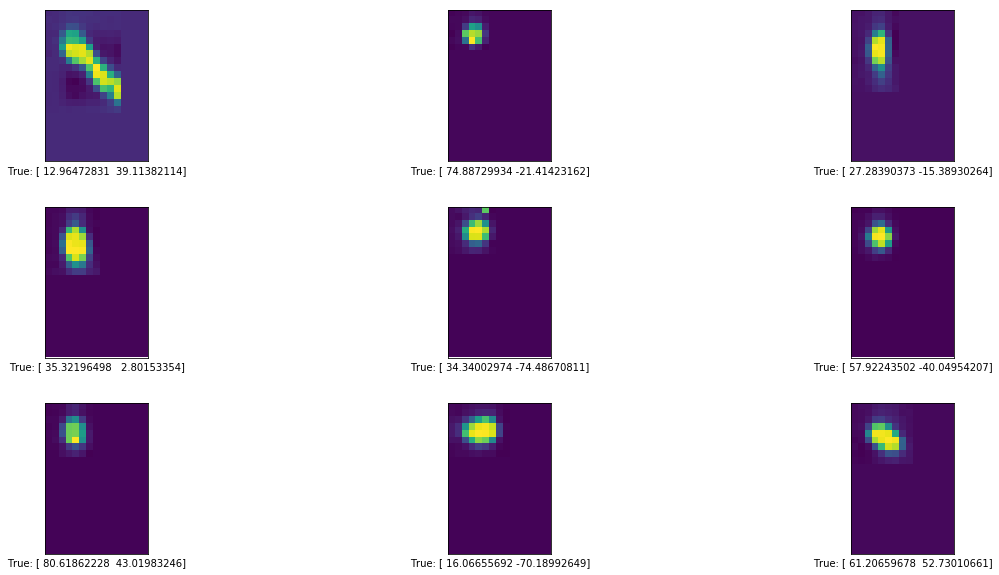

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Build Model

In [11]:
def new_weights(shape):
    #return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    global weightsCounter, GPU_USE
    weightsCounter = weightsCounter + 1
    with tf.device(GPU_USE):
        return vs.get_variable("weights"+str(weightsCounter), shape, initializer=tf.contrib.layers.xavier_initializer())

def new_biases(length):
    global biasesCounter, GPU_USE, bias_start
    biasesCounter = biasesCounter + 1
    with tf.device(GPU_USE):
        return vs.get_variable("bias"+str(biasesCounter), [length], initializer=init_ops.constant_initializer(bias_start))
        #return tf.Variable(tf.constant(0.05, shape=[length]))
        
# Helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    global GPU_USE
    with tf.device(GPU_USE):
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights aka. filters with the given shape.
        weights = new_weights(shape=shape)

        # Create new biases, one for each filter.
        biases = new_biases(length=num_filters)

        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        
        # strides = [batch, height, width, challens]
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

         
        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

        # Note that ReLU is normally executed before the pooling,
        # but since relu(max_pool(x)) == max_pool(relu(x)) we can
        # save 75% of the relu-operations by max-pooling first.

        # We return both the resulting layer and the filter-weights
        # because we will plot the weights later.
        return layer, weights

# Helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

# Helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 name=None): # Use Rectified Linear Unit (ReLU)?
    global GPU_USE
    with tf.device(GPU_USE):
        # Create new weights and biases.
        weights = new_weights(shape=[num_inputs, num_outputs])
        biases = new_biases(length=num_outputs)

        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        if name == None: 
            layer = tf.add(tf.matmul(input, weights), biases)
        else:
            layer = tf.add(tf.matmul(input, weights), biases, name=name)

        # Use ReLU?
        if use_relu:
            #layer = tf.contrib.layers.batch_norm(layer, center=True, scale=True)
            layer = tf.nn.softplus(layer)

        return layer, weights, biases


In [12]:
tf.reset_default_graph()
data.train.reset()
data.test.reset()

n_input_x = data.train.images[0].shape[0]
n_input_y = data.train.images[0].shape[1]
n_input = n_input_x * n_input_y
n_input_channels = 1
n_output = 2
# Number of colour channels for the images: 1 channel for gray-scale.


data.test.cls = np.argmax(data.test.labels, axis=1)


# Counter for total number of iterations performed so far.
num_iterations = 4000
train_batch_size = 100

### Convolutional Layer 1.
filter_size1 = 6
num_filters1 = 16*2

# Convolutional Layer 2.
filter_size2 = 6
num_filters2 = 36*2

#Convolutional Layer 3.
filter_size3 = 7
num_filters3 = 80*2
             
# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.


learning_rate = 0.02
decay_rate = 0.1
decay_steps = num_iterations
# learning_rate = 0.001
# decay_rate = 0.99
#decay_steps = num_iterations



weightsCounter = -1
biasesCounter = -1

bias_start = 0.01

with tf.device(GPU_USE):
    _x = tf.placeholder(tf.float32, shape=[None, n_input_x, n_input_y, n_input_channels], name="input_tensor")
    
    _y_true = tf.placeholder(tf.float32, shape=[None, n_output], name='y_true')
 
    testLen = int((len(data.test.labels)/train_batch_size))*train_batch_size
    _error = tf.Variable(tf.zeros([testLen]), dtype=tf.float32, name="error", trainable=False)   
    _errorPitch = tf.Variable(tf.zeros([testLen]), dtype=tf.float32, name="errorPitch", trainable=False)
    _errorYaw = tf.Variable(tf.zeros([testLen]), dtype=tf.float32, name="errorYaw", trainable=False)    
    
    _RMSE = tf.Variable(0, dtype=tf.float32, name="errorRMSE", trainable=False)
    _RMSEPitch = tf.Variable(0, dtype=tf.float32, name="errorPitchRMSE", trainable=False)
    _RMSEYaw = tf.Variable(0, dtype=tf.float32, name="errorYawRMSE", trainable=False)
    
    _global_step = tf.Variable(0, dtype=tf.int32, name="global_step", trainable=False)
    
    
variable_summaries(_RMSE, "errorRMSE")
variable_summaries(_RMSEPitch, "errorPitchRMSE")
variable_summaries(_RMSEYaw, "errorYawRMSE")

variable_summaries(_error, "error")
variable_summaries(_errorPitch, "errorPitch")
variable_summaries(_errorYaw, "errorYaw")

#layer_conv1
t, weights_conv1 = new_conv_layer(input=_x, num_input_channels=n_input_channels, filter_size=filter_size1,
                                  num_filters=num_filters1, use_pooling=True)
#layer_conv2
t, weights_conv2 = new_conv_layer(input=t, num_input_channels=num_filters1, filter_size=filter_size2,
                                  num_filters=num_filters2, use_pooling=True)
#layer_conv3
t, weights_conv3 = new_conv_layer(input=t, num_input_channels=num_filters2, filter_size=filter_size3,
                                    num_filters=num_filters3, use_pooling=True)

#layer_flat
t, num_features = flatten_layer(t)
#layer_fc1
t, weights_fc1, biases_fc1 = new_fc_layer(input=t, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
#layer_fc2
t, weights_fc2, biases_f2 = new_fc_layer(input=t, num_inputs=fc_size, num_outputs=n_output, use_relu=False, name="output_tensor")

y_pred = t
    
# Definition of cost function 
def distance(predictions, targets):
    with tf.device(GPU_USE):
        mean= tf.reduce_mean(tf.square(tf.subtract(predictions, targets)))
        if (mean == 0.0):
            mean = 0.0
        else:
            mean = tf.sqrt(mean)
        
        mean = tf.reduce_mean(mean +
            0.15*tf.nn.l2_loss(weights_fc1) +
            0.15*tf.nn.l2_loss(weights_fc2))
        return mean
    
cost = distance(y_pred, _y_true)

with tf.device(GPU_USE):
    learning_rate = tf.train.exponential_decay(learning_rate, _global_step, decay_steps, decay_rate)
    optimizer =  tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(cost, global_step=_global_step)

merged_summary = tf.summary.merge_all()

timestamp = int(time.time())
print ("Starting session %i %s" % (timestamp, datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')))
SAVE_PATH = tensorflowFolder + '/' + STORAGE_NAME + '/'+ str(timestamp) + '/'
print ("SAVE_PATH: %s" % SAVE_PATH)
train_writer = tf.summary.FileWriter(SAVE_PATH, graph=tf.get_default_graph())

init = tf.global_variables_initializer()

saver = tf.train.Saver()

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth=False
config.gpu_options.per_process_gpu_memory_fraction=0.1
config.gpu_options.allocator_type = 'BFC'


breakQueue=Queue()
breakEpochs = 15
with tf.device(GPU_USE):
    with tf.Session(config=config) as sess:
        sess.run(init)

        # Start-time used for printing tifme-usage below.
        start_time = time.time()

        len(data.train.images)
        for i in range(num_iterations):
            epochs = data.train.epochs_completed
            while True:
                x_batch, y_batch = data.train.next_batch(train_batch_size)

                #x_batch = x_batch.reshape([train_batch_size, x_batch[0].shape[0] * x_batch[0].shape[1]])
                _ = sess.run(optimizer, feed_dict={_x: x_batch, _y_true: y_batch})

                if epochs != data.train.epochs_completed:    
                    break
                    
            epochs = data.test.epochs_completed
            true_y = np.array([]) 
            pred_y = np.array([])
            while True:
                x_batch, y_batch = data.test.next_batch(train_batch_size)
                
                # Flatten only for NN nor for CNN
                #x_batch = x_batch.reshape([train_batch_size, n_input])
                #
                
                y_pred_batch = sess.run([y_pred], feed_dict= {_x: x_batch})#, _y_true: y_batch} )
                
                if len(true_y) == 0:
                    true_y = y_batch
                    pred_y = y_pred_batch[0]
                else:
                    true_y = np.concatenate((true_y, y_batch), axis=0)
                    pred_y = np.concatenate((pred_y, y_pred_batch[0]), axis=0)

                if epochs != data.test.epochs_completed:    
                    break
                    
            true_y = true_y[:testLen]
            pred_y = pred_y[:testLen]
                    
            ePitch = np.abs(true_y[:,0] - pred_y[:,0]) 
            eYaw = np.abs(true_y[:,1] - pred_y[:,1])
            ListError = ePitch + eYaw
            ListErrorPitch = ePitch
            ListErrorYaw = eYaw

            diff_true = true_y[:,0] + true_y[:,1]
            diff_pred = pred_y[:,0] + pred_y[:,1]
            RMSE = np.sqrt(np.mean(np.square(np.subtract(diff_pred, diff_true))))
            RMSEPitch = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,0], true_y[:,0]))))
            RMSEYaw   = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,1], true_y[:,1]))))
            
            op_assign_global_step = _global_step.assign(i)
            
            op_assign_error       = _error.assign(ListError.flatten())
            op_assign_error_Pitch = _errorPitch.assign(ListErrorPitch.flatten())
            op_assign_error_Yaw   = _errorYaw.assign(ListErrorYaw.flatten())
            
            op_assign_RMSE        = _RMSE.assign(RMSE)
            op_assign_RMSE_Pitch  = _RMSEPitch.assign(RMSEPitch)
            op_assign_RMSE_Yaw    = _RMSEYaw.assign(RMSEYaw)
            
            _ = sess.run([op_assign_global_step,
                          op_assign_error, op_assign_error_Pitch, op_assign_error_Yaw,
                          op_assign_RMSE, op_assign_RMSE_Pitch, op_assign_RMSE_Yaw])
            
            summary = sess.run(merged_summary)
            train_writer.add_summary(summary,  i)

            saver.save(sess, SAVE_PATH + "model", global_step=i, write_meta_graph=True)
        
            
            with open("./" + STORAGE_NAME + "_" + str(timestamp) + ".txt", "a") as text_file:
                text_file.write("%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s \n" %(
                    i, RMSE, RMSEPitch, RMSEYaw,
                    ListError.mean(), ListErrorPitch.mean(), ListErrorYaw.mean(),
                    ListError.std(), ListErrorPitch.std(), ListErrorYaw.std(),
                    time.time() - start_time))
        
            print ('%i RMSE: %.2f RMSE-P: %.2f RMSE-Y: %.2f e: %.2f E-P: %.2f E-Y: %.2f std: %.2f std-P: %.2f std-Y: %.2f time: %s' %(
                    i, RMSE, RMSEPitch, RMSEYaw,
                    ListError.mean(), ListErrorPitch.mean(), ListErrorYaw.mean(),
                    ListError.std(), ListErrorPitch.std(), ListErrorYaw.std(),
                    timedelta(seconds=int(round(time.time() - start_time)))))
        
        
            if (i > breakEpochs - 1):
                while (breakQueue.qsize() > breakEpochs):
                    breakQueue.get(0)


                break_mean = np.mean(list(breakQueue.queue))
                break_mean
                if (break_mean < RMSE):
                    print("BREAK AFTER %i epochs" % i)
                    break
                
            breakQueue.put(RMSE)

        # Ending time.
        end_time = time.time()

        # Difference between start and end-times.
        time_dif = end_time - start_time

        # Print the time-usage.
        print("Time usage: %s" % timedelta(seconds=int(round(time_dif))))

Starting session 1503618587 2017-08-25 01:49:47
SAVE_PATH: ./model/1503618587/
0 RMSE: 36.54 RMSE-P: 15.25 RMSE-Y: 31.45 e: 35.96 E-P: 12.47 E-Y: 23.50 std: 23.36 std-P: 8.79 std-Y: 20.91 time: 0:00:48
1 RMSE: 29.54 RMSE-P: 13.51 RMSE-Y: 26.39 e: 30.44 E-P: 10.75 E-Y: 19.69 std: 19.83 std-P: 8.18 std-Y: 17.57 time: 0:02:24
2 RMSE: 28.80 RMSE-P: 12.86 RMSE-Y: 25.58 e: 29.06 E-P: 10.25 E-Y: 18.81 std: 19.35 std-P: 7.77 std-Y: 17.34 time: 0:03:39
3 RMSE: 28.50 RMSE-P: 13.19 RMSE-Y: 26.52 e: 29.63 E-P: 10.45 E-Y: 19.18 std: 20.64 std-P: 8.04 std-Y: 18.32 time: 0:06:04
4 RMSE: 28.34 RMSE-P: 13.04 RMSE-Y: 24.92 e: 28.53 E-P: 10.32 E-Y: 18.21 std: 19.29 std-P: 7.96 std-Y: 17.01 time: 0:07:25
5 RMSE: 27.90 RMSE-P: 12.89 RMSE-Y: 25.06 e: 28.26 E-P: 10.18 E-Y: 18.07 std: 19.66 std-P: 7.90 std-Y: 17.36 time: 0:09:23
6 RMSE: 27.85 RMSE-P: 12.80 RMSE-Y: 24.66 e: 27.97 E-P: 10.14 E-Y: 17.84 std: 19.18 std-P: 7.81 std-Y: 17.03 time: 0:10:28
7 RMSE: 27.21 RMSE-P: 12.55 RMSE-Y: 24.25 e: 27.59 E-P: 9.95